In [1]:
import pickle
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.core.display import HTML, display

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from theano import shared
import theano.tensor as tt
import pymc3 as pm
from tqdm import tqdm

import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter
from seaborn import PairGrid, heatmap, kdeplot
import cmocean.cm as cmo
from pymc_utils import PyMCModel
from pymc_utils import subset_significant_feature
from pymc_utils import hs_regression
from pymc_utils import plot_fits_w_estimates

ImportError: cannot import name 'hs_regression'

In [ ]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
display(HTML("<style>.container{width: 90% !important}</style>"))

In [2]:
def PlotHeatMap(df, ax=None,):
    if ax is None:
        _, ax = pl.subplots(figsize=(20, 20))
    dfc = df.corr().iloc[1:, :-1]
    heatmap(dfc, vmin=-1, vmax=1, cmap=cmo.balance_r, annot=True, annot_kws={'fontsize': 13},
            ax=ax, mask=np.triu(np.ones([dfc.shape[1]]*2), k=1), fmt='.1f')
    ax.set_facecolor('k')
    return ax


def plot_obs_against_ppc(y_obs, ppc, ax=None, plot_1_to_1=False, **scatter_kwds):
    if ax is None:
        _, ax = pl.subplots(figsize=(10, 10))
    ppc_mean = ppc.mean(axis=0)
    ax.scatter(y_obs, ppc_mean, edgecolor='k', **scatter_kwds)
    if plot_1_to_1:
        min_ = min(ppc_mean.min(), y_obs.min())
        max_ = max(ppc_mean.max(), y_obs.max())
        ax.plot([min_, max_], [min_, max_], ls='--', color='k', label='1:1')


def evaluate_model(model,  y_train_, y_test_, ax1_title=None, ax2_title=None, ax3_title=None,):
    f = pl.figure(figsize=(15, 15))
    ax1 = pl.subplot2grid((2, 2), (0, 0))
    ax2 = pl.subplot2grid((2, 2), (0, 1))
    ax3 = pl.subplot2grid((2, 2), (1, 0), colspan=2)
    X_shared.set_value(X_s_train.values)
    ppc_train_ = model.predict(likelihood_name='likelihood' )
    model.plot_model_fits(y_train_, ppc_train_, loss_metric='mae',
                          ax=ax1, title=ax1_title, );
    X_shared.set_value(X_s_test.values)
    ppc_test_ = model.predict(likelihood_name='likelihood')
    model.plot_model_fits(y_test_, ppc_test_, loss_metric='mae',
                          ax=ax2, title=ax2_title, );
    plot_fits_w_estimates(y_test_, ppc_test_, ax=ax3)
    ax3.set_title(ax3_title)
    return f, ppc_train_, ppc_test_

def plot_fits_w_estimates(y_obs, ppc, ax=None, savename=False, steps=3):
    """ Plot Fits with Uncertainty Estimates"""
    iy  = np.argsort(y_obs)
    ix = np.arange(iy.size)
    lik_mean =ppc.mean(axis=0)
    lik_hpd = pm.hpd(ppc)
    lik_hpd_05 = pm.hpd(ppc, alpha=0.5)
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 8))
    if steps > 2:
        ax.scatter(ix, y_obs.values[iy], label='observed', edgecolor='k', s=120,
                   color='steelblue', marker='d', zorder=2);
    if steps > 1:
        ax.scatter(ix, lik_mean[iy], label='model mean', edgecolor='k', s=80,
                   color='m', zorder=3)
    
    ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], color='gray', 
                   label='model output 50%CI', zorder=1,linestyle='-', lw=2, edgecolor='k');
    ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], color='k', alpha=0.75,
                   label='model output 95%CI', zorder=0, );
    ax.legend(loc='upper left');
    if savename:
        f = pl.gcf()
        f.savefig('./figJar/bayesNet/bNN_L1_nobias.pdf', format='pdf')
    return ax

### <u>Modeling</u>

Below the smaller dataset (no interactions features one entry where all PC's are NaNs.
I just drop that row for now. To impute the missing predictors is a bit more complicated than when predicted values are missing.

In [4]:
with open('./pickleJar/AphiTrainTestSplitDataSets.pkl', 'rb') as fb:
    datadict = pickle.load(fb)
X_s_train = datadict['x_train_s']
y_train = datadict['y_train']
X_s_test = datadict['x_test_s']
y_test = datadict['y_test']

In [5]:
predictor_renamedict = {'log10_etopo2_s': 'dep',
                        'oisst_s': 'sst', 'solz_s': 'solz',
                        'PC1_s': 'pc1', 'PC2_s': 'pc2', 'PC3_s': 'pc3',
                        'PC4_s': 'pc4', 'PC5_s': 'pc5', 'PC6_s': 'pc6'}

In [6]:
X_s_train.rename(columns= predictor_renamedict, inplace=True)
X_s_test.rename(columns=predictor_renamedict, inplace=True)

In [7]:
poly_tranf = PolynomialFeatures(interaction_only=True, include_bias=False)

In [8]:
X_s_train_w_int = pd.DataFrame(poly_tranf.fit_transform(X_s_train), columns=poly_tranf.get_feature_names(input_features=X_s_train.columns), index=X_s_train.index)
X_s_test_w_int = pd.DataFrame(poly_tranf.fit_transform(X_s_test), columns=poly_tranf.get_feature_names(input_features=X_s_train.columns), index=X_s_test.index)

In [9]:
X_s_train_w_int.head()

,dep,sst,solz,pc1,pc2,pc3,pc4,pc5,pc6,dep sst,...,pc2 pc3,pc2 pc4,pc2 pc5,pc2 pc6,pc3 pc4,pc3 pc5,pc3 pc6,pc4 pc5,pc4 pc6,pc5 pc6
104,1.561812,0.980019,-0.652818,0.189974,-0.414644,-0.933887,-0.510384,0.285450,0.064361,1.530605,...,0.387230,0.211627,-0.118360,-0.026687,0.476641,-0.266578,-0.060106,-0.145689,-0.032849,0.018372
98,1.667105,-0.455988,-0.472027,0.579478,-0.554825,-0.349339,-0.066203,-1.129648,0.660823,-0.760180,...,0.193822,0.036731,0.626757,-0.366641,0.023127,0.394630,-0.230851,0.074786,-0.043748,-0.746497
16,-0.768789,-0.912078,0.498893,-0.484867,0.421179,-0.301039,0.747057,-0.227188,-0.363760,0.701195,...,-0.126791,0.314645,-0.095687,-0.153208,-0.224893,0.068392,0.109506,-0.169722,-0.271749,0.082642
75,-0.742689,1.387941,-0.873786,0.084072,-0.869452,-0.196910,1.052647,0.434195,-0.296654,-1.030809,...,0.171204,-0.915226,-0.377512,0.257926,-0.207277,-0.085497,0.058414,0.457055,-0.312272,-0.128806
18,-1.067195,0.055796,1.208669,-1.146327,2.335666,-1.018783,-0.174597,1.969049,-1.271384,-0.059546,...,-2.379536,-0.407800,4.599041,-2.969529,0.177876,-2.006033,1.295264,-0.343789,0.221979,-2.503417


In [10]:
X_s_test_w_int.head()

,dep,sst,solz,pc1,pc2,pc3,pc4,pc5,pc6,dep sst,...,pc2 pc3,pc2 pc4,pc2 pc5,pc2 pc6,pc3 pc4,pc3 pc5,pc3 pc6,pc4 pc5,pc4 pc6,pc5 pc6
158,-1.067195,0.088912,1.409549,-2.062600,1.317990,1.726068,-0.440037,0.428693,0.087233,-0.094886,...,2.274940,-0.579964,0.565013,0.114973,-0.759533,0.739953,0.150570,-0.188640,-0.038386,0.037396
109,0.651093,-1.101740,1.583645,-0.284452,0.555198,-0.260618,1.651467,-0.241092,1.271284,-0.717335,...,-0.144695,0.916891,-0.133854,0.705814,-0.430402,0.062833,-0.331320,-0.398156,2.099484,-0.306497
131,0.713891,-1.015940,0.726557,-0.398845,0.741764,0.282082,1.318181,0.431949,1.027741,-0.725270,...,0.209239,0.977780,0.320405,0.762342,0.371836,0.121845,0.289907,0.569388,1.354749,0.443932
55,-1.016488,1.034208,-1.851402,0.836086,-1.094915,0.342000,0.270907,0.756488,-1.576699,-1.051260,...,-0.374460,-0.296620,-0.828290,1.726352,0.092650,0.258719,-0.539230,0.204938,-0.427139,-1.192754
94,1.632113,0.986040,-1.061274,2.103904,-0.817134,2.430645,0.325330,0.672708,-0.315151,1.609329,...,-1.986163,-0.265839,-0.549692,0.257521,0.790763,1.635114,-0.766021,0.218852,-0.102528,-0.212005


In [11]:
datadict['x_train_s'] = X_s_train
datadict['y_train'] = y_train
datadict['x_test_s'] = X_s_test
datadict['y_test'] = y_test
datadict['x_train_wi_s'] = X_s_train_w_int
datadict['x_test_wi_s'] = X_s_test_w_int
with open('./pickleJar/AphiTrainTestSplitDataSets.pkl', 'wb') as fb:
    pickle.dump(datadict, fb, protocol=pickle.HIGHEST_PROTOCOL)

### A$\phi$ 411

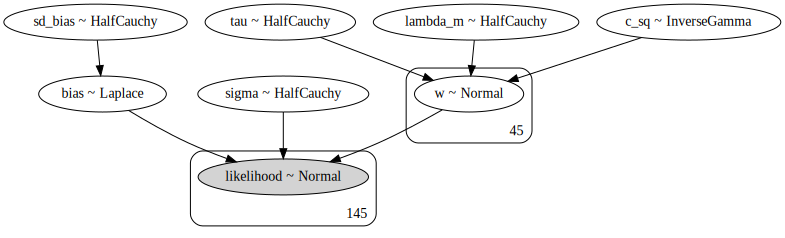

In [17]:
X_shared = shared(X_s_train_w_int.values)
m_hshoe_411 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy411, model_name='hshoe_aphy411_wi',
                        ylabel='likelihood', regularized=True)
m_hshoe_411.show_model()

In [19]:
m_hshoe_411.fit(tune=10000, cores=1, chains=4, nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
100%|██████████| 12000/12000 [03:54<00:00, 51.21it/s]


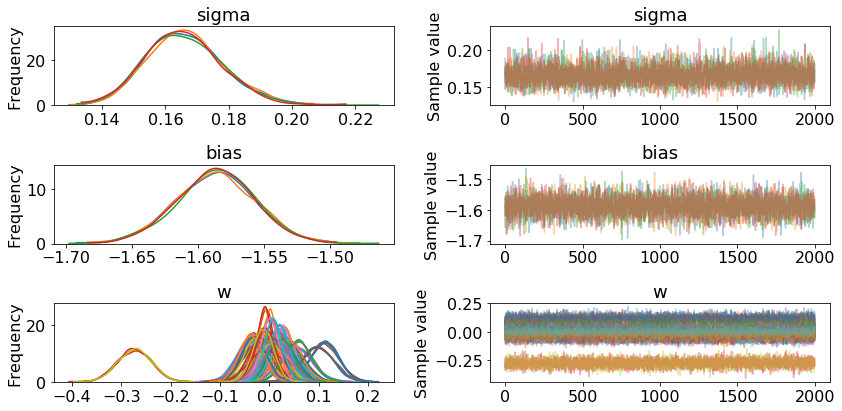

In [20]:
m_hshoe_411.evaluate_fit(['sigma',  'bias', 'w']);

In [22]:
feature_labels = X_s_train_w_int.columns

In [23]:
significant_features = subset_significant_feature(m_hshoe_411.trace_, feature_labels, vars_=['w'])

In [24]:
significant_features

['PC1_s', 'PC3_s', 'solz_s PC4_s', 'PC1_s PC2_s']

In [36]:
data_dict = dict(X_s_train=X_s_train_w_int, X_s_test=X_s_test_w_int,
                y_train=y_train, y_test=y_test, 
                significant_features=significant_features)
with open('./pickleJar/data_w_interactions_dict.pkl', 'wb') as fb:
    pickle.dump(data_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

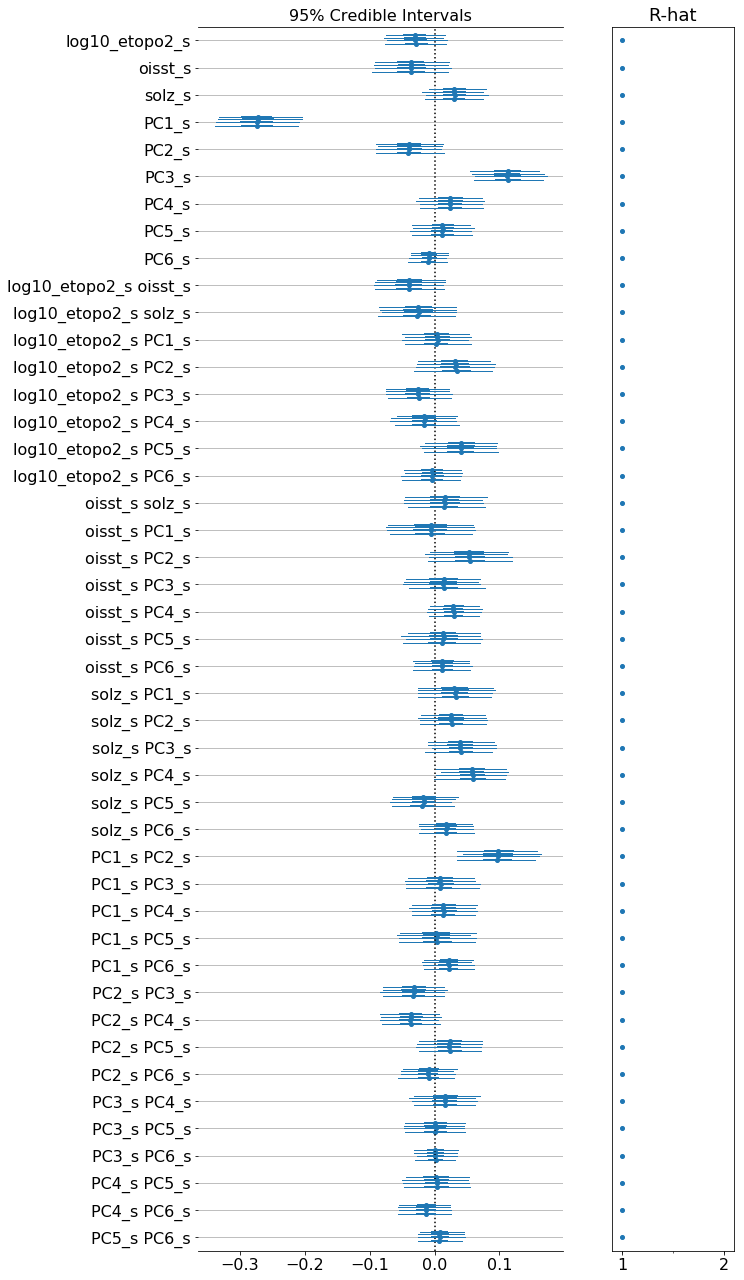

In [25]:
m_hshoe_411.show_forest(['w'], feat_labels=feature_labels);
f = pl.gcf()
f.set_figheight(20)
f.set_figwidth(12)
#f.savefig('./figJar/APHI411_foresplot.png', dpi=300, format='png')

In [27]:
X_shared.set_value(X_s_train_w_int)

In [28]:
ppc_train_411 = m_hshoe_411.predict(likelihood_name='likelihood')

100%|██████████| 8000/8000 [00:06<00:00, 1182.57it/s]


In [31]:
X_shared.set_value(X_s_test_w_int)

In [32]:
ppc_test_411 = m_hshoe_411.predict(likelihood_name='likelihood')

100%|██████████| 8000/8000 [00:07<00:00, 1069.34it/s]


In [33]:
ppc_train_411.shape, ppc_test_411.shape

((8000, 145), (8000, 17))

In [35]:
results_dict = {411: dict(model=m_hshoe_411.model, 
                          trace = m_hshoe_411.trace_,
                          ppc_train=ppc_train_411,
                          ppc_test=ppc_test_411)
               }
with open('./pickleJar/HSHOE_MDL_W_INTERACTIONS_DICT.pkl', 'wb') as fb:
    pickle.dump(results_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)            

In [50]:
with open('../../WRITEUPS/TOA_ML_Writeup/hs_model_wi_411.pkl', 'wb') as f:
    pickle.dump(m_hshoe_411, f)

In [ ]:
X_shared.set_value(X_s_test.values)
ppc_test_411 = m_hshoe_411.predict(likelihood_name='likelihood')

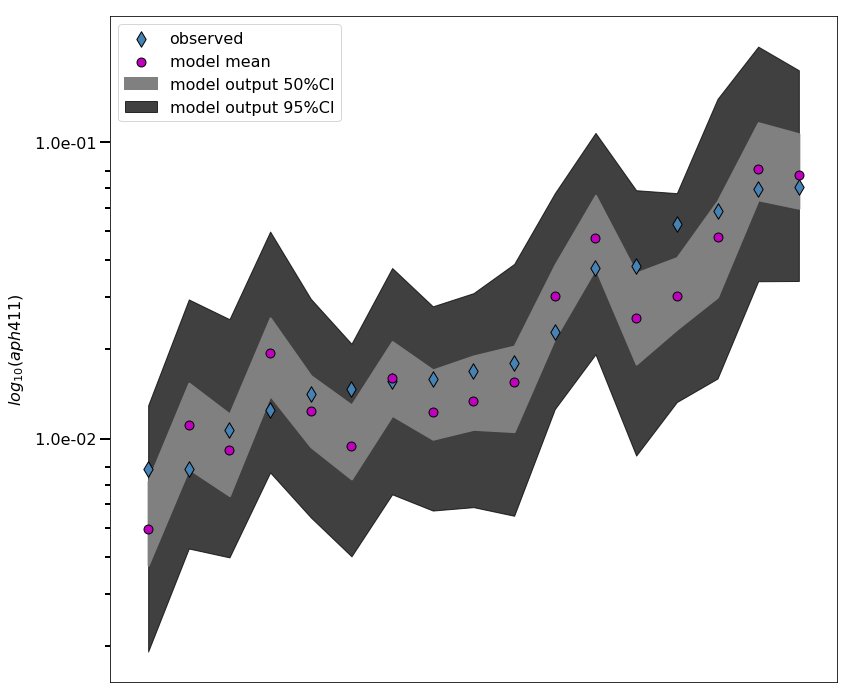

In [53]:
f, ax = pl.subplots(figsize=(12, 10))
ax = plot_fits_w_estimates(y_test.log10_aphy411, ppc_test_411, ax=ax)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 411)$')
ax.set_yticks(np.log10(np.asarray([1e-2, 1e-1])))
minor_ticks = np.concatenate((np.arange(2e-3, 9e-3, 1e-3), np.arange(2e-2, 9e-2, 1e-2)))
ax.set_yticks(np.log10(minor_ticks), minor=True)
ax.tick_params(axis='y', which='minor', length=5, width=2)
ax.tick_params(axis='y', which='major', length=10, width=2)
ax.tick_params(axis='x', which='both', length=0, width=0)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
f.tight_layout()
f.savefig('../../WRITEUPS/TOA_ML_Writeup/FigJar/ppc_2_hs_wi_aphi_411.pdf', dpi=300, format='pdf')

In [56]:
with open('../../WRITEUPS/TOA_ML_Writeup/ppc_2.pkl', 'wb') as fb:
    picledict = dict(ytest=y_test.log10_aphy411.values, ppc=ppc_test_411)
    pickle.dump(picledict, fb)

### A$\phi$ 443

In [84]:
X_shared.set_value(X_s_train.values)
m_hshoe_443 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy443, model_name='hshoe_aphy443_wi',
                        ylabel='likelihood', regularized=True)
m_hshoe_443.fit(tune=7000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 36000/36000 [01:11<00:00, 500.28draws/s]
There were 284 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7158720072078956, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8999623456815528, but should be close to 0.8. Try to increase the number of tuning steps.
There were 236 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.675039687572507, but should be close to 0.8. Try to increase the number of tuning steps.


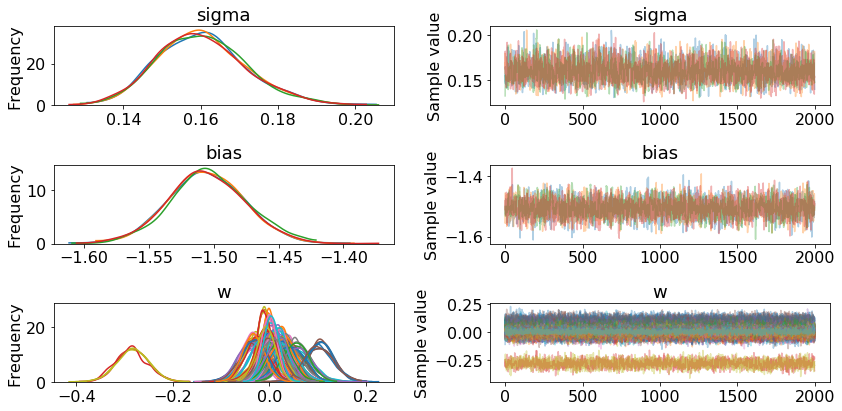

In [61]:
m_hshoe_443.evaluate_fit(['sigma',  'bias', 'w']);

In [70]:
X_shared.set_value(X_s_test.values)
ppc_test_443 = m_hshoe_443.predict(likelihood_name='likelihood')

100%|██████████| 2000/2000 [00:01<00:00, 1264.44it/s]


### A$\phi$ 489

In [86]:
X_shared.set_value(X_s_train.values)
m_hshoe_489 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy489, model_name='hshoe_aphy489_wi',
                        ylabel='likelihood', regularized=True)
m_hshoe_489.fit(tune=7000, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 36000/36000 [01:18<00:00, 458.67draws/s]


In [75]:
X_shared.set_value(X_s_test.values)
ppc_test_489 = m_hshoe_489.predict(likelihood_name='likelihood')

100%|██████████| 2000/2000 [00:01<00:00, 1254.19it/s]


In [76]:
X_shared.set_value(X_s_train.values)
m_hshoe_510 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy510, model_name='hshoe_aphy510_wi',
                        ylabel='likelihood', regularized=True)
m_hshoe_510.fit(tune=7000, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 36000/36000 [01:19<00:00, 454.87draws/s]
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6988243094002018, but should be close to 0.85. Try to increase the number of tuning steps.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7172281992719134, but should be close to 0.85. Try to increase the number of tuning steps.


In [78]:
X_shared.set_value(X_s_test.values)
ppc_test_510 = m_hshoe_510.predict(likelihood_name='likelihood')

100%|██████████| 2000/2000 [00:01<00:00, 1252.33it/s]


In [79]:
X_shared.set_value(X_s_train.values)
m_hshoe_555 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy555, model_name='hshoe_aphy555',
                        ylabel='likelihood', regularized=True)
m_hshoe_555.fit(tune=7000, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 36000/36000 [01:17<00:00, 462.18draws/s]
There were 209 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6978720231385186, but should be close to 0.85. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 251 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7142313141730431, but should be close to 0.85. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


In [80]:
X_shared.set_value(X_s_test.values)
ppc_test_555 = m_hshoe_555.predict(likelihood_name='likelihood')

100%|██████████| 2000/2000 [00:01<00:00, 1243.88it/s]


In [81]:
X_shared.set_value(X_s_train.values)
m_hshoe_670 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy670, model_name='hshoe_aphy670_wi',
                        ylabel='likelihood', regularized=True)
m_hshoe_670.fit(tune=7000, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 36000/36000 [01:23<00:00, 126.08draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 217 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5076841617435461, but should be close to 0.85. Try to increase the number of tuning steps.


In [82]:
X_shared.set_value(X_s_test.values)
ppc_test_670 = m_hshoe_670.predict(likelihood_name='likelihood')

100%|██████████| 2000/2000 [00:01<00:00, 1273.77it/s]


In [34]:
X_shared.set_value(X_s_train.values)
pickleModelDict = {m_hshoe_411.model.name: m_hshoe_411, 
                   m_hshoe_443.model.name: m_hshoe_443,
                   m_hshoe_489.model.name: m_hshoe_489,
                   m_hshoe_510.model.name: m_hshoe_510,
                   m_hshoe_555.model.name: m_hshoe_555,
                   m_hshoe_670.model.name: m_hshoe_670}
with open('./pickleJar/Models/HS_Prior_With_Int_All_APhys.pkl', 'wb') as f:
    pickle.dump(pickleModelDict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [87]:
mae_411 = mean_absolute_error(y_test.log10_aphy411.values, ppc_test_411.mean(axis=0))
mae_443 = mean_absolute_error(y_test.log10_aphy443.values, ppc_test_443.mean(axis=0))
mae_489 = mean_absolute_error(y_test.log10_aphy489.values, ppc_test_489.mean(axis=0))
mae_510 = mean_absolute_error(y_test.log10_aphy510.values, ppc_test_510.mean(axis=0))
mae_555 = mean_absolute_error(y_test.log10_aphy555.values, ppc_test_555.mean(axis=0))
mae_670 = mean_absolute_error(y_test.log10_aphy670.values, ppc_test_670.mean(axis=0))

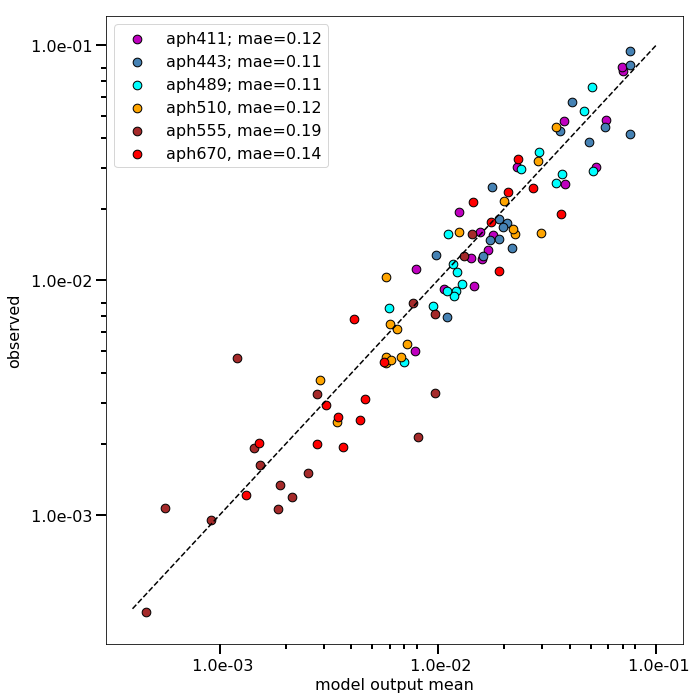

In [93]:
minor_ticks = np.concatenate((np.arange(5e-4, 9e-4, 1e-4), np.arange(2e-3, 9e-3, 1e-3),
                              np.arange(2e-2, 9e-2, 1e-2)))
f, ax_ = pl.subplots(figsize=(10, 10))
plot_obs_against_ppc(y_test.log10_aphy411, ppc_test_411, color='m',
                     label=f'aph411; mae={mae_411:.2f}', s=75, ax=ax_) 
plot_obs_against_ppc(y_test.log10_aphy443, ppc_test_443, color='steelblue', ax=ax_,
                     label=f'aph443; mae={mae_443:.2f}', s=75,)
plot_obs_against_ppc(y_test.log10_aphy489, ppc_test_489, color='cyan', ax=ax_,
                     label=f'aph489; mae={mae_489:.2f}', s=75, )
plot_obs_against_ppc(y_test.log10_aphy510, ppc_test_510, color='orange', ax=ax_,
                     label=f'aph510, mae={mae_510:.2f}', s=75,)
plot_obs_against_ppc(y_test.log10_aphy555, ppc_test_555, color='brown', ax=ax_,
                     label=f'aph555, mae={mae_555:.2f}', s=75, )
plot_obs_against_ppc(y_test.log10_aphy670, ppc_test_670, color='red', ax=ax_,
                     label=f'aph670, mae={mae_670:.2f}', s=75, )
ax_.plot([-3.4, -1], [-3.4, -1], color='k', ls='--')
ax_.legend()
ax_.set_xlabel('model output mean')
ax_.set_ylabel('observed')
ax_.set_yticks(np.log10(np.asarray([1e-3, 1e-2, 1e-1])))
ax_.set_xticks(np.log10(np.asarray([1e-3, 1e-2, 1e-1])))
ax_.set_yticks(np.log10(minor_ticks), minor=True)
ax_.set_xticks(np.log10(minor_ticks), minor=True)
ax_.tick_params(axis='both', which='minor', length=5, width=2)
ax_.tick_params(axis='both', which='major', length=10, width=2)
ax_.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
ax_.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
f.tight_layout()
f.savefig('../../WRITEUPS/TOA_ML_Writeup/FigJar/test_2.pdf', format='pdf', dpi=300)

In [91]:
with open('../../WRITEUPS/TOA_ML_Writeup/test2.pkl', 'wb') as fb:
    test_dict = dict(y_test = y_test,
                    ppc={'411': ppc_test_411, '443': ppc_test_443, '489': ppc_test_489,
                        '510': ppc_test_510, '555': ppc_test_555, '670': ppc_test_670},
                    mae={'411': mae_411, '443': mae_443, '489': mae_489, '510': mae_510,
                        '555': mae_555, '670': mae_670})
    pickle.dump(test_dict, fb)